This is the main notebook where we will redistrict Iowa.

In [17]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 


## for laplacian
from scipy.sparse import csgraph

## for nullspace
from scipy.linalg import null_space

# Prepping the census and geopandas dataframes

## Importing data

In [18]:
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [19]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3996,1790,2114,92,3811,1133,2461,217,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157..."
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,2185,1028,1108,49,2106,565,1395,146,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158..."
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,6934,3553,3264,117,6923,2421,4093,409,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500..."
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,6245,2951,3161,133,6136,1814,4033,289,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812..."
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,3457,1611,1802,44,3412,1080,2136,196,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688..."


In [20]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4
top_fifth_percentile=int(np.percentile(census_df['population'],95))

## Merging pd and gpd dataframes and creating population heat map

In [21]:
map_population_by_county_data = shapefile_iowa.merge(census_df, on='COUNTYFP10')
census_df.sort_values('population', ascending=False).head()

,county_id,county,population,COUNTYFP10,latitude,longitude
76,76,Polk,492401,153,41.684281,-93.569720
56,56,Linn,230299,113,42.077951,-91.597673
81,81,Scott,174669,163,41.641679,-90.622290
51,51,Johnson,152854,103,41.668737,-91.588812
6,6,Black Hawk,131144,013,42.472888,-92.306059


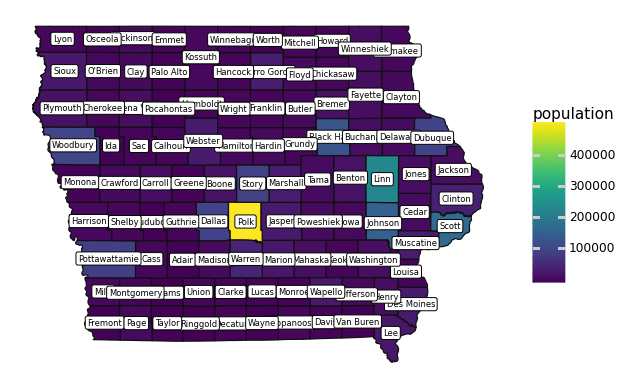

<ggplot: (379747019)>

In [22]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

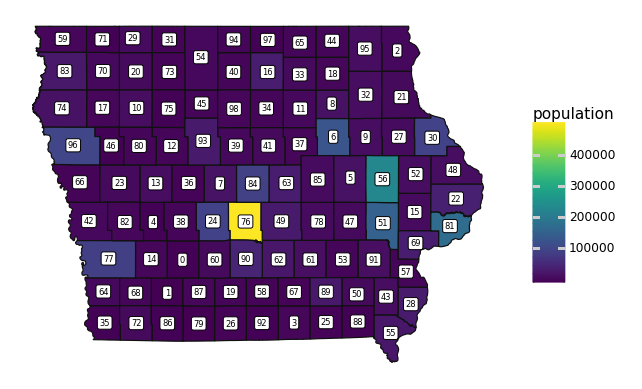

<ggplot: (379769634)>

In [23]:
map_by_county_id = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_by_county_id

# Creating the adjacency matrix for Iowa counties

In [24]:
# full statewide adjacency matrix (first boolean, then casting as int)
#   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
#   also should do this operation after any sorting of the original shapefile

ia_adjac_matrix = pd.DataFrame()

for j in range(n_counties):
    ia_adjac_matrix[j] = shapefile_iowa.intersects(shapefile_iowa.iloc[[j]].unary_union)
ia_adjac_matrix = ia_adjac_matrix - np.identity(99)
ia_adjac_matrix = ia_adjac_matrix.astype(int)

ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)



# Optimization Model

## Creating decision variables, model, and objective function

In [25]:
# zero padding county id in order to keep counties in alphabetical order for variable names
zp_county=np.array((census_df['county_id']).astype(str).str.pad(2,fillchar='0'))
zp_county

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54',
       '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76',
       '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87',
       '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98'],
      dtype=object)

In [26]:
ideal_district_size=state_population/n_districts
tolerance=.01
district_maximum=int(ideal_district_size*(1+tolerance))
district_minimum=int(ideal_district_size*(1-tolerance))

In [27]:
# Create the linear programming model.
model = LpProblem("Supply-Demand-Problem", LpMinimize) 
variable_names = [zp_county[i]+str(j) for j in range(n_districts)
                                for i in range(n_counties)]
variable_names.sort() 

# The Decision Variable is 1 if the county is assigned to the district.
DV_variable_y = LpVariable.matrix("Y", variable_names, cat="Binary")
assignment = np.array(DV_variable_y).reshape(n_counties,n_districts)

# # The Decision Variable is the population allocated to the district.
DV_variable_x = LpVariable.matrix("X", variable_names, cat="Integer",
                                  lowBound=0)
allocation = np.array(DV_variable_x).reshape(n_counties,n_districts)

In [28]:
# This objective minimizes the counties split among multiple districts.
objective_function = lpSum(assignment) 
model += objective_function

In [29]:
assignment[:,1][ia_adjac_matrix_bool[0]]

array([Y_011, Y_041, Y_141, Y_241, Y_381, Y_601, Y_871], dtype=object)

## Initial Assignment / Allocation Constraints

In [30]:
# Allocate 100% of the population from each county.
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_populations[i] , "Allocate All " + str(i)

# This constraint makes assignment required for allocation.
# sum(county_populations) is the "big M"
for i in range(n_counties): 
    for j in range(n_districts):
        model += allocation[i][j] <= county_populations[i]*assignment[i][j] , "Allocation assignment of county" + str(i) + "to district" + str(j)
        model += allocation[i][j] >= .2*county_populations[i]*assignment[i][j], "Minimum allocation of county" + str(i) + "to" + str(j)

# Contiguous districts constraints
# set minimum number of neighbors
neighbor_min=3
for j in range(n_districts):
    for i in range(n_counties):
        model += neighbor_min*assignment[i][j] <= lpSum(assignment[:,j][ia_adjac_matrix_bool[i]]), "Contiguity constraint for county " + str(i) +" in district " + str(j)

# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= district_maximum , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= district_minimum , "District Size Minimum " + str(j)

# Only allow counties that meet certain critera to be split among multiple districts
# This not necessary for Iowa.
for i in range(n_counties): 
    if county_populations[i] <= top_fifth_percentile: 
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment for county " + str(i) 
    else:
        model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments for county " + str(i)

In [31]:
model.solve(GLPK_CMD(options=["--mipgap", "0.05", "--gomory"])) 

print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/lj/f1ygs8y13w9crbf6d4d7mgcm0000gn/T/1530e1d28c9a4faaac4d8f93cb5d12f5-pulp.lp
 -o /var/folders/lj/f1ygs8y13w9crbf6d4d7mgcm0000gn/T/1530e1d28c9a4faaac4d8f93cb5d12f5-pulp.sol
 --mipgap 0.05 --gomory
Reading problem data from '/var/folders/lj/f1ygs8y13w9crbf6d4d7mgcm0000gn/T/1530e1d28c9a4faaac4d8f93cb5d12f5-pulp.lp'...
1394 rows, 792 columns, 5916 non-zeros
792 integer variables, 396 of which are binary
3117 lines were read
GLPK Integer Optimizer 5.0
1394 rows, 792 columns, 5916 non-zeros
792 integer variables, 396 of which are binary
Preprocessing...
1394 rows, 792 columns, 5916 non-zeros
792 integer variables, 396 of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.924e+05  ratio =  4.924e+05
GM: min|aij| =  3.844e-01  max|aij| =  2.601e+00  ratio =  6.766e+00
EQ: min|aij| =  1.579e-01  max|aij| =  1.000e+00  ratio =  6.331e+00
2N: min|aij| =  1.250e-01  max|aij| =  1.631e

In [32]:
# Access the results
for i in range(n_counties):
    for j in range(n_districts):
        if allocation[i][j].value() > 0:
            print('County %d assigned to district %d: ' % (i, j), allocation[i][j].value())

County 0 assigned to district 2:  7496
County 1 assigned to district 3:  3704
County 2 assigned to district 1:  14061
County 3 assigned to district 2:  12317
County 4 assigned to district 0:  5674
County 5 assigned to district 2:  25575
County 6 assigned to district 3:  131144
County 7 assigned to district 0:  26715
County 8 assigned to district 3:  24988
County 9 assigned to district 1:  20565
County 10 assigned to district 3:  20823
County 11 assigned to district 3:  14334
County 12 assigned to district 0:  9927
County 13 assigned to district 0:  20760
County 14 assigned to district 3:  13127
County 15 assigned to district 1:  18505
County 16 assigned to district 3:  43127
County 17 assigned to district 2:  11658
County 18 assigned to district 3:  12012
County 19 assigned to district 0:  9748
County 20 assigned to district 3:  16384
County 21 assigned to district 1:  17043
County 22 assigned to district 1:  46460
County 23 assigned to district 0:  16525
County 24 assigned to district

# Visualizing the districts

## Prepping the data for visualization

In [33]:
# Prepare data for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'county_id': i,
            'district': j+1,
            'assignment': int(assignment[i][j].value()*(j+1)),
            'allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['assignment'] != 0]
results = results.sort_values(['county_id', 'district'])
results


,county_id,district,assignment,allocation
2,0,3,3,7496
7,1,4,4,3704
9,2,2,2,14061
14,3,3,3,12317
16,4,1,1,5674
...,...,...,...,...
379,94,4,4,10679
381,95,2,2,20070
384,96,1,1,105941
391,97,4,4,7443


In [34]:
results = results.merge(census_df, on='county_id')
results

,county_id,district,assignment,allocation,county,population,COUNTYFP10,latitude,longitude
0,0,3,3,7496,Adair,7496,001,41.328528,-94.478164
1,1,4,4,3704,Adams,3704,003,41.021656,-94.696906
2,2,2,2,14061,Allamakee,14061,005,43.274964,-91.382751
3,3,3,3,12317,Appanoose,12317,007,40.744683,-92.870345
4,4,1,1,5674,Audubon,5674,009,41.679178,-94.904312
...,...,...,...,...,...,...,...,...,...
96,94,4,4,10679,Winnebago,10679,189,43.378124,-93.743488
97,95,2,2,20070,Winneshiek,20070,191,43.292989,-91.850788
98,96,1,1,105941,Woodbury,105941,193,42.393220,-96.053296
99,97,4,4,7443,Worth,7443,195,43.373491,-93.248533


In [35]:
results.loc[(results['allocation'])!=(results['population'])]

,county_id,district,assignment,allocation,county,population,COUNTYFP10,latitude,longitude
51,51,2,2,30571,Johnson,152854,103,41.668737,-91.588812
52,51,3,3,122283,Johnson,152854,103,41.668737,-91.588812
77,76,1,1,393920,Polk,492401,153,41.684281,-93.569720
78,76,3,3,98481,Polk,492401,153,41.684281,-93.569720


In [36]:
# results_test=results.copy()

In [37]:
# results_test['multiple_county_name'] = results_test['county'].shift(periods=1)
# results_test['multiple_district'] = results_test['district'].shift(periods=1).fillna(99).astype(int)


In [38]:
# results_test

In [39]:
# Edit the assignment for the case when a county has multiple assignments 
# for i in range(0,len(results_test)):
#     if results_test['county'].loc[i] == results_test['multiple_county_name'].loc[i]:
#         results_test.loc[i, 'assignment'] =   int(str(results_test['district'].loc[i]) + \
#                                                         str(results_test['multiple_district'].loc[i]))
# results_test = results_test.sort_values(['district','county'])
# results_test.index = results_test['county_id']

In [40]:
# results_test.loc[results_test['county_id']==76]

## Creating the maps

In [41]:
color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

def iowa_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with county IDs labels
    (2) A map with county labels
    """
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county_id',size=2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    # plot_map_county_ids = (
    #     ggplot(map_data)
    # + geom_map(aes(fill=str('Assignment'))) 
    # + geom_label(aes(x='longitude', y='latitude', label='population', size=5), 
    #              show_legend=False)
    # + theme_minimal()
    # + theme(axis_text_x=element_blank(),
    #         axis_text_y=element_blank(),
    #         axis_title_x=element_blank(),
    #         axis_title_y=element_blank(),
    #         axis_ticks=element_blank(),
    #         panel_grid_major=element_blank(),
    #         panel_grid_minor=element_blank(),
    #         figure_size=(7, 4))
    # + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels
# , plot_map_county_ids


In [42]:
shapefile_and_assignments = shapefile_iowa.merge(results, on='COUNTYFP10')
# map_first_pass['District'] = map_first_pass['District']+1
shapefile_and_assignments.head()


,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,CD,geometry,county_id,district,assignment,allocation,county,population,latitude,longitude
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157...",0,3,3,7496,Adair,7496,41.328528,-94.478164
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158...",1,4,4,3704,Adams,3704,41.021656,-94.696906
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500...",2,2,2,14061,Allamakee,14061,43.274964,-91.382751
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812...",3,3,3,12317,Appanoose,12317,40.744683,-92.870345
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688...",4,1,1,5674,Audubon,5674,41.679178,-94.904312


In [43]:
# map_first_pass['District'] = map_first_pass['District'].astype('category')
shapefile_and_assignments['assignment'] = shapefile_and_assignments['assignment'].astype("category")

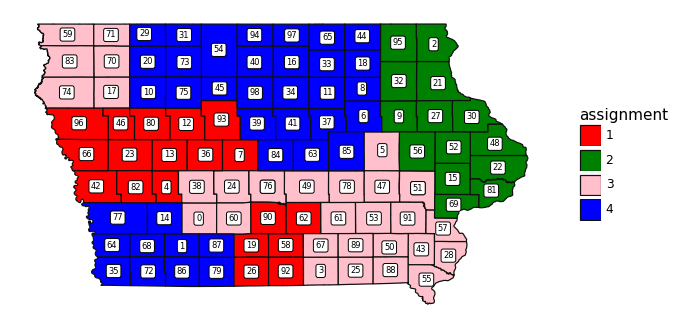

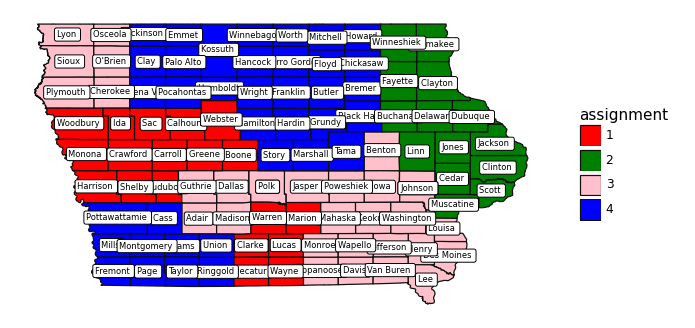

(<ggplot: (379143036)>, <ggplot: (381451063)>)

In [44]:
iowa_map(shapefile_and_assignments)

In [45]:
district_totals = pd.DataFrame(results.groupby('district')['allocation'].sum().astype('int64'))
district_totals

,allocation
district,
1,795471
2,791872
3,805236
4,797790


# Laplacian

In [46]:
# #a vector of the indices of the adjacency matrix,
# dist1counties=results['county_id'].loc[results['assignment']==1]
# dist2counties=results['county_id'].loc[results['assignment']==2]
# dist3counties=results['county_id'].loc[results['assignment']==3]
# dist4counties=results['county_id'].loc[results['assignment']==4]

# # district1adj = ia_adjac_matrix.loc[results['assignment']==1,results['assignment']==1]
# # this makes pd dataframes
# district1adj = ia_adjac_matrix.loc[dist1counties, dist1counties]
# district2adj = ia_adjac_matrix.loc[dist2counties, dist2counties]
# district3adj = ia_adjac_matrix.loc[dist3counties, dist3counties]
# district4adj = ia_adjac_matrix.loc[dist4counties, dist4counties]

# ######  requires new loaded thing (now at top):
# # from scipy.sparse import csgraph
# # input has to be a numpy array
# LaplDist1array = csgraph.laplacian(district1adj.to_numpy())
# LaplDist2array = csgraph.laplacian(district2adj.to_numpy())
# LaplDist3array = csgraph.laplacian(district3adj.to_numpy())
# LaplDist4array = csgraph.laplacian(district4adj.to_numpy())

# # convert back to a dataframe instead of an array
# LaplDist1DF = pd.DataFrame(LaplDist1array,columns=dist1counties,index=dist1counties)
# LaplDist2DF = pd.DataFrame(LaplDist2array,columns=dist2counties,index=dist2counties)
# LaplDist3DF = pd.DataFrame(LaplDist3array,columns=dist3counties,index=dist3counties)
# LaplDist4DF = pd.DataFrame(LaplDist4array,columns=dist4counties,index=dist4counties)

In [47]:
# district 1 is 2 connected component, with 20 counties
# null_space(LaplDist1array).shape

In [48]:
# dist1_ConnCom = null_space(LaplDist1array).shape[1]
# dist2_ConnCom = null_space(LaplDist2array).shape[1]
# dist3_ConnCom = null_space(LaplDist3array).shape[1]
# dist4_ConnCom = null_space(LaplDist4array).shape[1]

In [49]:
# ConnCom = [dist1_ConnCom, dist2_ConnCom, dist3_ConnCom, dist4_ConnCom]
# for i in range(n_districts):
#     print('District %d has %d connected component(s).' % (i+1, ConnCom[i]))

In [50]:
dist_counties=[]
dist_laplacian=[]
Laplacian_kernel=[]
conn_comp=[]

for i in range(n_districts):
    dist_counties.append(results['county_id'].loc[results['assignment']==i+1].to_list())

for i in range(n_districts):
    dist_laplacian.append(csgraph.laplacian(ia_adjac_matrix.loc[dist_counties[i], dist_counties[i]].to_numpy()))
    Laplacian_kernel.append(null_space(dist_laplacian[i]))
    conn_comp.append(null_space(dist_laplacian[i]).shape[1])
print(conn_comp)
print('Total number of connected components is ', sum(conn_comp))

[1, 1, 2, 2]
Total number of connected components is  6


Polk county is ID 76. It is split across Districts 1 and 3. Based on the plot in the above section, it is not evident that Districts 1 and 3 are individually contiguous. However, there is no way to split Polk county in a way that makes the overall district map contiguous.

To do for next time:

- Begin converting PuLP to pyomo
- reframe laplacian in terms of allocation/assignment variables
- reset objective function as minimizing the total number of connected components

In [54]:
results.to_csv('PuLP_results.csv',index=False,header=True)

### Converting Laplacian initializiation to use assignment np array in initialization of model

In [51]:
#create list of empty lists. Each list will be populated with county IDs of the district corresponding to the list entry's index
dist_counties_index=[]
for i in range(n_districts):
    dist_counties_index.append([])


In [52]:
#grab the county ID of each county in district i
for j in range(n_districts):
    for i in range(n_counties):
        # will assignment[i][i] spit out the X_(county)(district) label or the 0/1 binary value? Need the latter
        if assignment[i][j]==1:
            dist_counties_index[j].append(i)

In [53]:
district_laplacians=[]
laplacian_kernels=[]
conn_components=[]
for i in range(n_districts):
    #Grabs the submatrix from IA adjacency matrix corresponding to each district and computes the laplacian of the submatrix and appends to a list of laplacians
    district_laplacians.append(csgraph.laplacian(ia_adjac_matrix.loc[dist_counties_index[i], dist_counties_index[i]].to_numpy()))
    laplacian_kernels.append(null_space(district_laplacians[i]))
    conn_components.append(null_space(district_laplacians[i]).shape[1])

Minimize sum of connected components!